In [1]:
import os
os.environ["PROJ_LIB"] = r'C:\Users\Mic Mic\anaconda3\pkgs\basemap-1.3.0-py38ha7665c8_0\Library\share\basemap' #fixr

from mpl_toolkits.basemap import Basemap, maskoceans
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import netCDF4 as nc
import scipy.io as sp
import numpy.random as rnd

## Get days with strong amihan

In [2]:
training_days = np.load('../strong_amihan_noTC.npy')

### Get latitudes and longitudes of set domain

In [3]:
slp_latitude = np.arange(5,41,1.25)
slp_longitude = np.arange(110,141,1.25)

## Read csv file containing SLP of strong Habagat days

In [4]:
strong_amihan_slp = pd.read_csv('strong_amihan_slp.csv',header=None).values

## Get random indices for training (90% of total)

In [5]:
training_count = np.round(0.9*strong_amihan_slp.shape[1])
test_count = strong_amihan_slp.shape[1]-training_count

rng = rnd.default_rng(seed=0)
training_index = rng.choice(int(strong_amihan_slp.shape[1]), size=int(training_count), replace=False)

In [6]:
total_points = np.arange(strong_amihan_slp.shape[1])
test_index = np.array([i for i in total_points if i not in training_index])

In [7]:
np.save('../Training/Large Domain/test_index.npy',test_index)
np.save('../Training/Large Domain/training_index.npy',training_index)

### Get randomized training and test SLP

In [8]:
training_SLP = strong_amihan_slp[:,training_index]/strong_amihan_slp[:,training_index].max(axis=0)
test_SLP = strong_amihan_slp[:,test_index]/strong_amihan_slp[:,test_index].max(axis=0)

### Save randomized training and test set to CSV

In [9]:
np.savetxt('../Training/Large Domain/training_SLP.csv',training_SLP,delimiter=',')
np.savetxt('../Training/Large Domain/test_SLP.csv',test_SLP,delimiter=',')

## Read archetypes and weights

In [10]:
MVSA_daily_slp = pd.read_csv('../Training/Large Domain/slp_training_MVSA.csv',header=None)
daily_slp_weights = pd.read_csv('../Training/Large Domain/slp_training_weights.csv',header=None).values

## Find days with threshold SLP weights

In [11]:
slp_archetypes, slp_days = np.where(daily_slp_weights>0.6)

In [12]:
slp_arch_index = training_index[slp_days]
slp_archetype_dates = np.array(training_days)[np.unique(slp_arch_index)]

In [13]:
np.savetxt('../Training/Large Domain/slp_match_days.txt',np.array(slp_archetype_dates).astype(int))

In [14]:
#get years with archetype dates
years = []
for date in slp_archetype_dates:
    years.append(date[:4])

## Filter RH of days that match SLP patterns

In [15]:
strong_amihan_rh = pd.read_csv('../strong_amihan_rh.csv',header=None).values

normal_rh = strong_amihan_rh/strong_amihan_rh.max(axis=1)[:,None]

#get training values
training_rh = normal_rh[:,training_index]
#get test values
test_rh = normal_rh[:,test_index]

#get RH of days with matching SLP
matched_rh = training_rh[:,np.unique(slp_days)].T

In [16]:
#save matching RH to csv
np.savetxt('../Training/Large Domain/training_RH.csv',matched_rh,delimiter=',')

#save test RH to csv
np.savetxt('../Training/Large Domain/test_RH.csv',test_rh.T,delimiter=',')

## Get days with analogous RH using threshold

In [17]:
#read csv files of archetypes and weights
MVSA_daily_rh = pd.read_csv('../Training/Large Domain/rh_training_MVSA.csv',header=None)
daily_rh_weights = pd.read_csv('../Training/Large Domain/rh_training_weights.csv',header=None).values

#get RHs with dominant archetypes
rh_archetypes, rh_days = np.where(daily_rh_weights>0.6)
rh_archetype_dates = np.array(slp_archetype_dates)[rh_days]

#get years with archetype dates
years = []
for date in rh_archetype_dates:
    years.append(date[:4])

In [18]:
total_mean_rain = np.zeros((191,160,daily_rh_weights.shape[0]))

for j in range(daily_rh_weights.shape[0]):
    index = np.where(rh_archetypes == j)[0]

    year = np.array(years)[index]
    dates = rh_archetype_dates[index]
    days_index = rh_days[index]

    total_rain_matrix = np.zeros((len(dates),160,191))

    for k in range(len(dates)):
        try:
            daily_rain = nc.Dataset('../../Daily Rain/gpm'+year[k]+'/3B-DAY.MS.MRG.3IMERG.'\
                                +dates[k]+'-S000000-E235959.V06.nc4.nc4')
        except FileNotFoundError:
            continue

        rain_data = np.ma.getdata(daily_rain['precipitationCal'][0,:,:])

        total_rain_matrix[k] = rain_data

    #get median total rain
    mean_rain = np.median(total_rain_matrix,axis=0)

    total_mean_rain[:,:,j] = mean_rain.T

np.save('../Training/Large Domain/rh_training_rain.npy',total_mean_rain)

## Calculate scaling between actual and composite

In [19]:
composite_rain_map = np.zeros((total_mean_rain.shape[0],total_mean_rain.shape[1],daily_rh_weights.shape[1]))
actual_rain_map = np.copy(composite_rain_map)

for a in range(daily_rh_weights.shape[1]):
    composite_rain_map[:,:,a] = np.sum(daily_rh_weights[:,a]*total_mean_rain,axis=2)
    
    date = slp_archetype_dates[a]
    year = date[:4]
    
    try:
        daily_rain = nc.Dataset('../../Daily Rain/gpm'+year+'/3B-DAY.MS.MRG.3IMERG.'\
                            +date+'-S000000-E235959.V06.nc4.nc4')
    except FileNotFoundError:
        continue
    
    actual_rain_map[:,:,a] = (np.ma.getdata(daily_rain['precipitationCal'][0,:,:])).T

In [20]:
scale = np.mean(actual_rain_map[26:91,90:130],axis=(0,1))/np.mean(composite_rain_map[26:91,90:130],axis=(0,1))
scale = scale[scale!=0]

In [21]:
np.mean(scale)

0.6909921896776301

## Get data on observed rainfall from PAGASA stations

In [22]:
station_id = pd.read_csv('../../Strong Habagat/sta_id.csv',header=None)
station_lon = station_id[1].values
station_lat = station_id[2].values

In [23]:
#consider only weather stations in east Philippines

#find stations at <12 degrees N
lat_ind = station_lat < 13.1 #12.5
station_lat = station_lat[lat_ind]
station_lon = station_lon[lat_ind]

#find stations at >124 degrees E
lon_ind = station_lon > 123 #124.5 
station_lon = station_lon[lon_ind]
station_lat = station_lat[lon_ind]

In [24]:
#get station information of east PH stations
east_PH_df = station_id[(station_id[1].isin(station_lon)) & (station_id[2].isin(station_lat))]

#get indices of east PH stations
east_PH = east_PH_df.index

In [25]:
daily_rain = nc.Dataset('../../Daily Rain/gpm2015/3B-DAY.MS.MRG.3IMERG.20150101-S000000-E235959.V06.nc4.nc4')

#get rainfall latitudes
rain_latitude = np.ma.getdata(daily_rain['lat'])

#get rainfall longitudes
rain_longitude = np.ma.getdata(daily_rain['lon'])

### Find (nearest) index of stations in rainfall grid

In [26]:
lon_ind = []
lat_ind = []

#find nearest corresponding index of stations in rain grid
for i in range(len(station_lon)):
    lon_index = np.abs(rain_longitude-station_lon[i]).argmin()
    lat_index = np.abs(rain_latitude-station_lat[i]).argmin()
    
    lon_ind.append(lon_index)
    lat_ind.append(lat_index)    

In [27]:
#save longitude indices in array
np.save('station_lon_index.npy',lon_ind)

#save latitude indices in array
np.save('station_lat_index.npy',lat_ind)

#save east PH indices in arrray
np.save('eastPH_index.npy',east_PH)

### Load observed rainfall per station 

In [28]:
eastPH = np.load('eastPH_index.npy')
obs_rain = pd.read_csv('../obs_strong_amihan.csv',header=None).values[:,eastPH]

test_obs_rain = obs_rain[test_index]
train_obs_rain = obs_rain[np.unique(slp_days)]

### Load indices of longitude and latitude of PAGASA stations in rain grid

In [29]:
station_lon = np.load('station_lon_index.npy')
station_lat = np.load('station_lat_index.npy')

## Compare forecast and actual rainfall, and calculate contingency table

In [30]:
#heavy rain threshold
threshold_rain = [0.5,20]

#neighbour size of forecast
N = [1,2]

#create array containing contingency table per day for different threshold and neighbour size
cont_table = np.zeros((train_obs_rain.shape[0],5,len(threshold_rain),len(N)))


for t in range(len(threshold_rain)):
    for n in range(len(N)):
        for a in range(train_obs_rain.shape[0]):
            #get composite rain
            composite_rain = 0.6909921896776301*composite_rain_map[:,:,a] 
            
            for b in range(train_obs_rain.shape[1]):
                lat_index = station_lat[b]
                lon_index = station_lon[b]

                #get actual station rain
                actual_station_rain = train_obs_rain[a][b]

                #check if observed rain is missing
                if np.isnan(actual_station_rain):
                    cont_table[a,4,t] += 1

                else:
                    #get composite station rain within grid
                    composite_station_rain = composite_rain[lat_index-N[n]:lat_index+(N[n]+1), \
                                                            lon_index-N[n]:lon_index+(N[n]+1)]

                    #compare actual rain to grid of forecast
                    diff = np.abs(actual_station_rain-composite_station_rain).argmin()
                    forecast_station_rain = composite_station_rain.flatten()[diff]

                    #count hits per day
                    if actual_station_rain >= threshold_rain[t] and forecast_station_rain >= threshold_rain[t]:
                        cont_table[a,0,t,n] += 1

                    #count false alarms per day
                    elif actual_station_rain < threshold_rain[t] and forecast_station_rain >= threshold_rain[t]:
                        cont_table[a,1,t,n] += 1

                    #count misses per day
                    elif actual_station_rain >= threshold_rain[t] and forecast_station_rain < threshold_rain[t]:
                        cont_table[a,2,t,n] += 1

                    #count correct negatives per day
                    else:
                        cont_table[a,3,t,n] += 1

## Calculate contingency scores

In [31]:
# 0 = hits
# 1 = false alarms
# 2 = misses
# 3 = correct negatives

#calculate threat score
ts = cont_table[:,0,:,:]/(cont_table[:,0,:,:]+cont_table[:,1,:,:]+cont_table[:,2,:,:])

#calculate bias
bias = (cont_table[:,0,:,:]+cont_table[:,1,:,:])/(cont_table[:,0,:,:]+cont_table[:,2,:,:])

#calculate probability of detection
pod = cont_table[:,0,:,:]/(cont_table[:,0,:,:]+cont_table[:,2,:,:])

#calculate false alarm ratio
far = cont_table[:,1,:,:]/(cont_table[:,0,:,:]+cont_table[:,1,:,:])

<ipython-input-31-380e9cbdd595>:7: RuntimeWarning: invalid value encountered in true_divide
  ts = cont_table[:,0,:,:]/(cont_table[:,0,:,:]+cont_table[:,1,:,:]+cont_table[:,2,:,:])
<ipython-input-31-380e9cbdd595>:10: RuntimeWarning: divide by zero encountered in true_divide
  bias = (cont_table[:,0,:,:]+cont_table[:,1,:,:])/(cont_table[:,0,:,:]+cont_table[:,2,:,:])
<ipython-input-31-380e9cbdd595>:10: RuntimeWarning: invalid value encountered in true_divide
  bias = (cont_table[:,0,:,:]+cont_table[:,1,:,:])/(cont_table[:,0,:,:]+cont_table[:,2,:,:])
<ipython-input-31-380e9cbdd595>:13: RuntimeWarning: invalid value encountered in true_divide
  pod = cont_table[:,0,:,:]/(cont_table[:,0,:,:]+cont_table[:,2,:,:])
<ipython-input-31-380e9cbdd595>:16: RuntimeWarning: invalid value encountered in true_divide
  far = cont_table[:,1,:,:]/(cont_table[:,0,:,:]+cont_table[:,1,:,:])


In [32]:
np.nanmean(np.ma.masked_invalid(ts),axis=0)

masked_array(
  data=[[0.6149166 , 0.64854575],
        [0.17663711, 0.24795821]],
  mask=False,
  fill_value=1e+20)

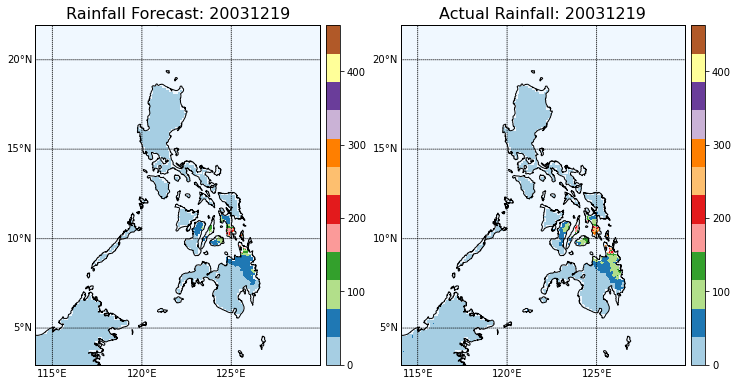

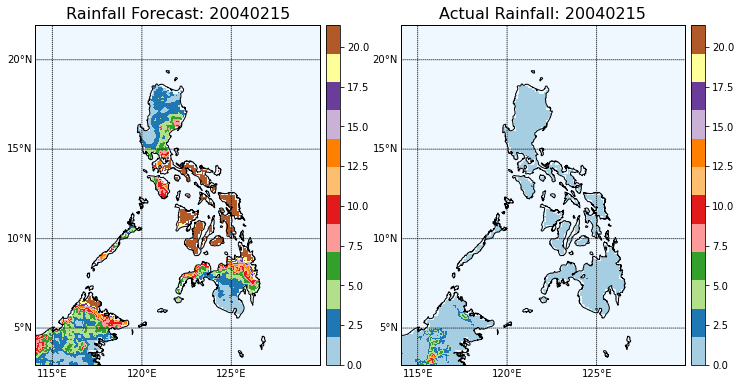

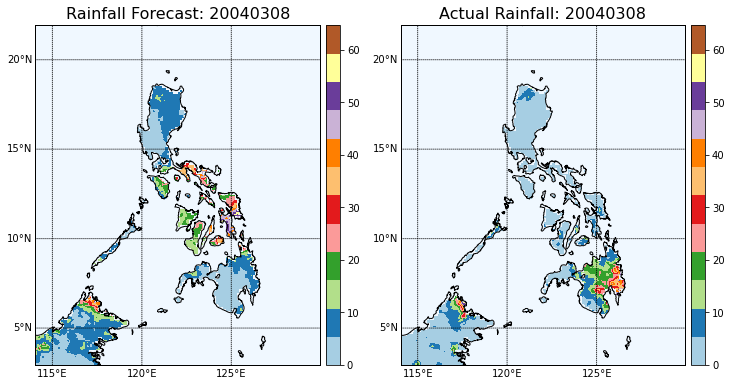

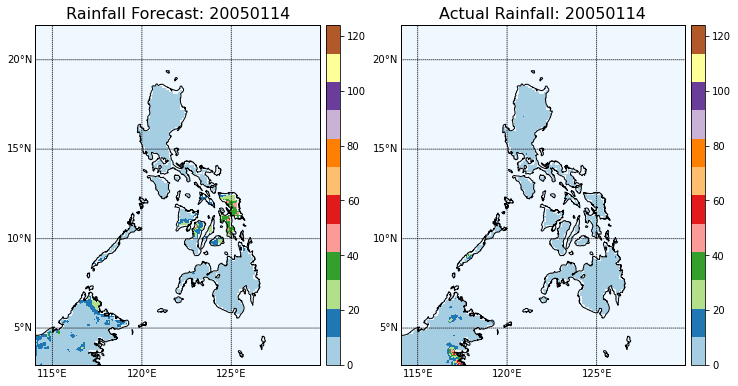

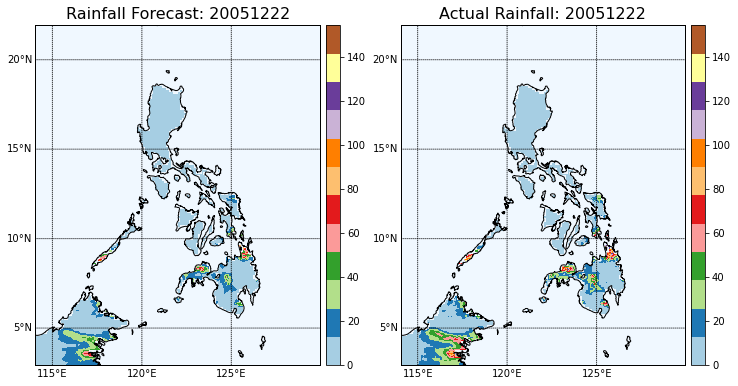

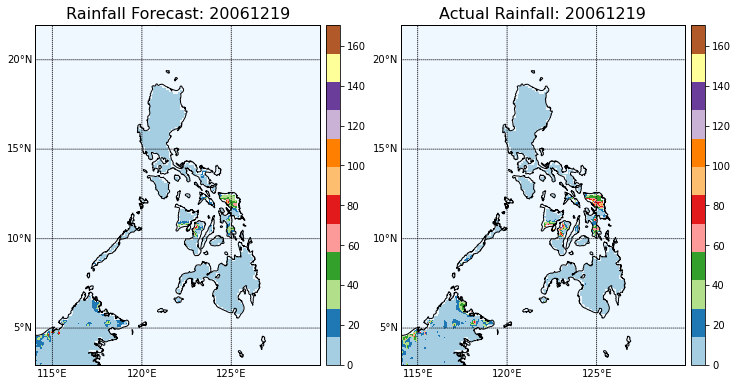

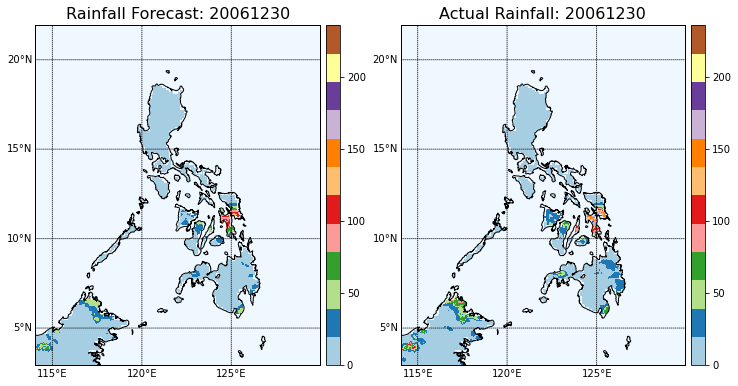

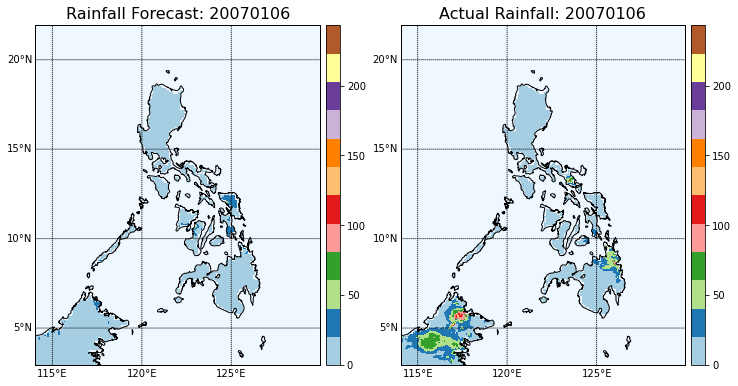

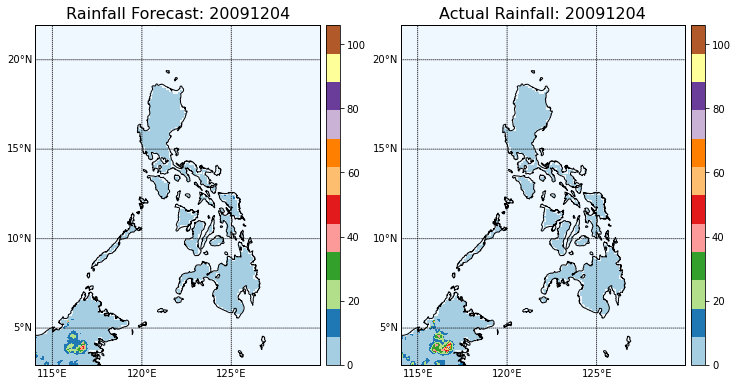

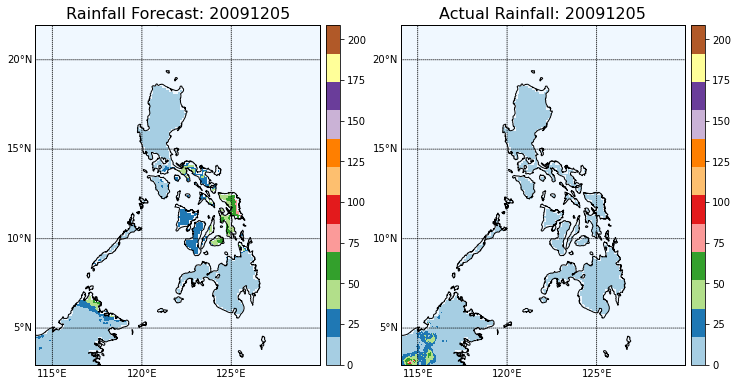

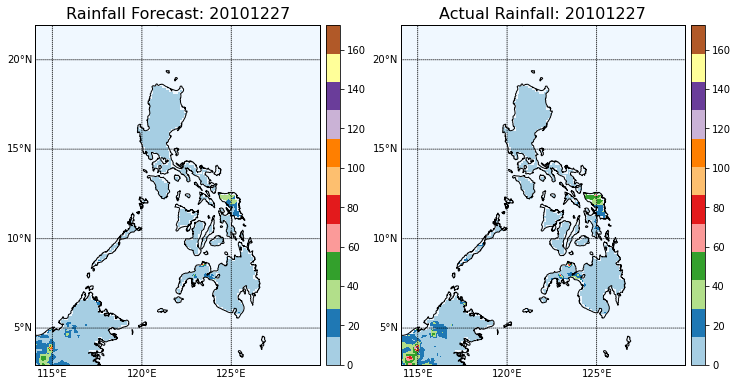

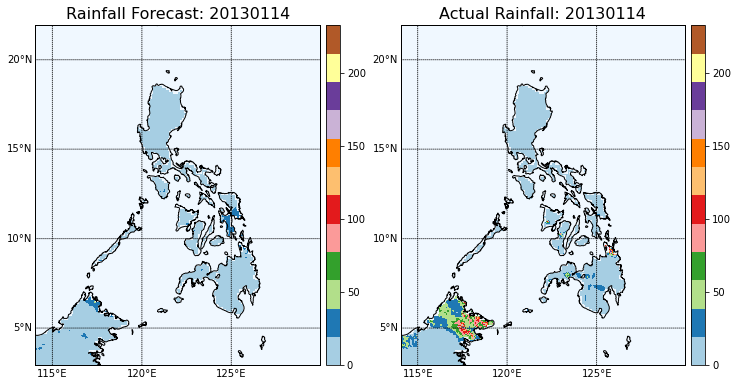

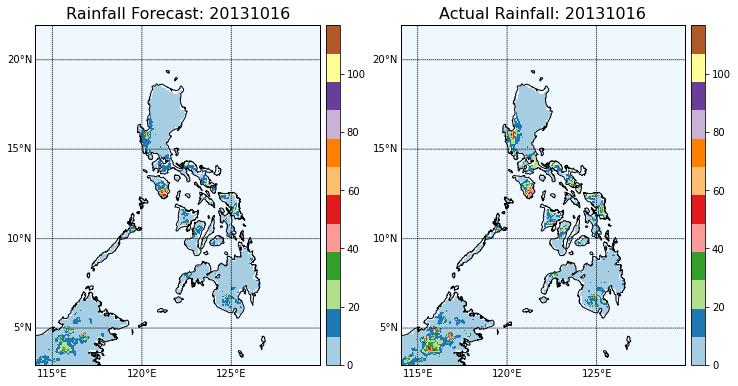

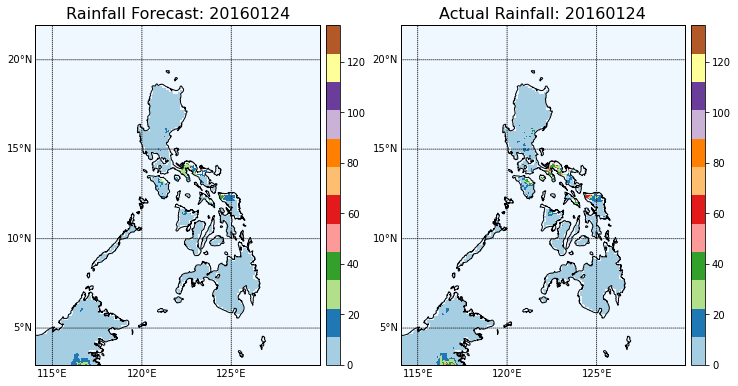

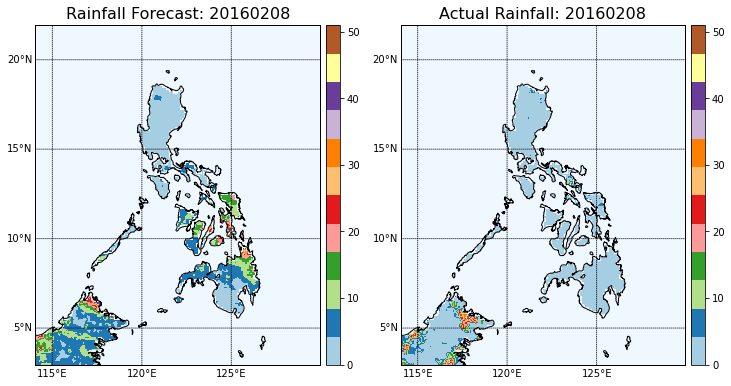

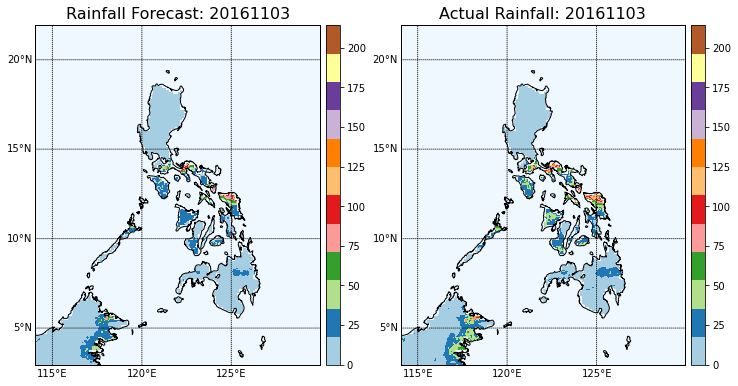

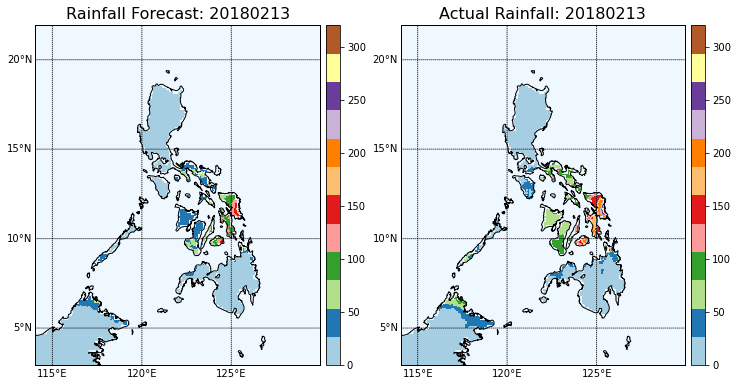

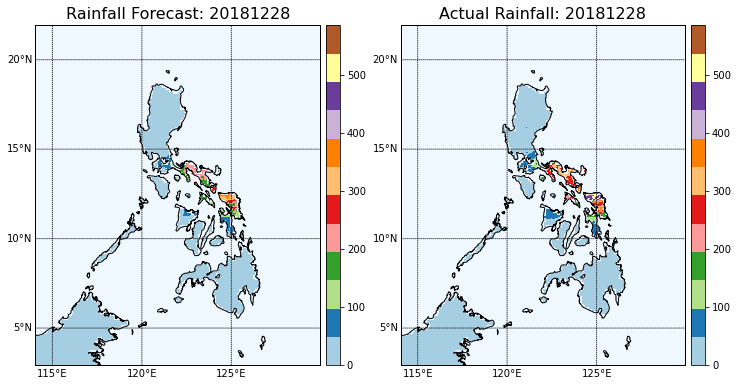

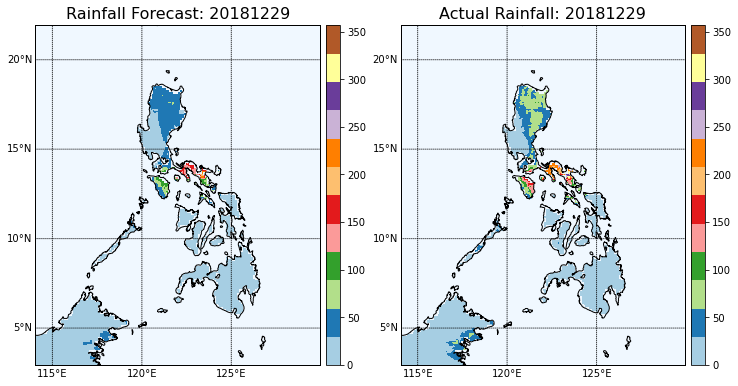

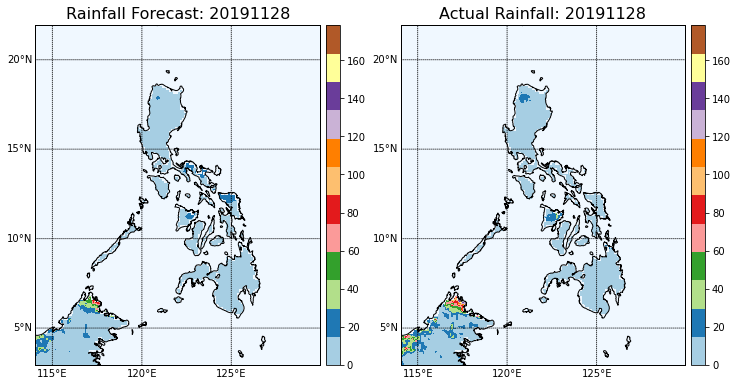

In [33]:
#get latitudes
rain_latitude = np.ma.getdata(daily_rain['lat'])
#get longitudes
rain_longitude = np.ma.getdata(daily_rain['lon'])

lon, lat = np.meshgrid(rain_longitude,rain_latitude)

for j in range(composite_rain_map.shape[2]):
    #get masked actual rain
    actual_rain = actual_rain_map[:,:,j]
    masked_actual = maskoceans(lon,lat,actual_rain,resolution='i')

    #get masked composite rain
    composite_rain = 0.6909921896776301*composite_rain_map[:,:,j] 
    masked_composite = maskoceans(lon,lat,composite_rain,resolution='i')

    fig = plt.figure(figsize=(12, 10))

    #show archetype rain map
    fig.add_subplot(1, 2, 1)

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=114.05,urcrnrlon=129.95,llcrnrlat=2.95,urcrnrlat=21.95,resolution='i')
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(fill_color='aliceblue')

    composite_rain_imshow = m.imshow(masked_composite,cmap='Paired',zorder=1,\
                                     vmin=np.min(masked_actual),vmax=np.max(masked_actual))
    plt.title('Rainfall Forecast: '+slp_archetype_dates[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,21,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(115,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])

    m.colorbar(composite_rain_imshow,'right',shrink=0.5)

    #show actual rain map
    fig.add_subplot(1, 2, 2)

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=114.05,urcrnrlon=129.95,llcrnrlat=2.95,urcrnrlat=21.95,resolution='i')
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(fill_color='aliceblue')

    actual_rain_imshow = m.imshow(masked_actual,cmap='Paired',zorder=1) 
    plt.title('Actual Rainfall: '+slp_archetype_dates[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,21,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(115,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])

    m.colorbar(actual_rain_imshow,'right',shrink=0.5)
    
    plt.show()

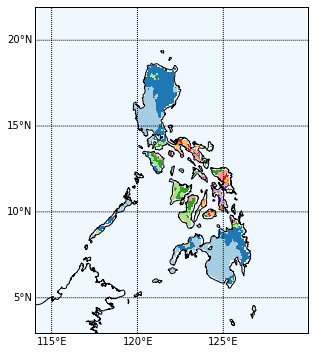

In [33]:
#get latitudes
rain_latitude = np.ma.getdata(daily_rain['lat'])
#get longitudes
rain_longitude = np.ma.getdata(daily_rain['lon'])

lon, lat = np.meshgrid(rain_longitude,rain_latitude)

for j in [2]:#range(composite_rain_map.shape[2]):
    #get masked actual rain
    actual_rain = actual_rain_map[:,:,j] 
    masked_actual = maskoceans(lon,lat,actual_rain,resolution='i')
    masked_actual.mask[:41,:52] = True

    #get masked composite rain
    composite_rain = 0.6909921896776301*composite_rain_map[:,:,j] 
    masked_composite = maskoceans(lon,lat,composite_rain,resolution='i')
    masked_composite.mask[:41,:52] = True

    fig = plt.figure(figsize=(8, 6))

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=114.05,urcrnrlon=129.95,llcrnrlat=2.95,urcrnrlat=21.95,resolution='i')
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(fill_color='aliceblue')

    composite_rain_imshow = m.imshow(masked_composite,cmap='Paired',zorder=1,\
                                     vmin=np.min(masked_actual),vmax=np.max(masked_actual))
#     plt.title('Rainfall Forecast: '+slp_archetype_dates[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,21,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(115,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])

#     m.colorbar(composite_rain_imshow,'right',shrink=0.5)
    
#     #display contingency scores at 50mm threshold, N=1
#     plt.text(133,22,'HRT = '+str(threshold_rain[0])+' mm, N = '+str(N[0]*2 + 1),fontsize=11)
#     plt.text(134.5,21,'TS = '+str(np.round(ts[j,0,0],3)),fontsize=10)
#     plt.text(134.5,20,'BIAS = '+str(np.round(bias[j,0,0],3)),fontsize=10)
#     plt.text(134.5,19,'POD = '+str(np.round(pod[j,0,0],3)),fontsize=10)
#     plt.text(134.5,18,'FAR = '+str(np.round(far[j,0,0],3)),fontsize=10)

#     #display contingency scores at 75mm threshold, N=1
#     plt.text(133,17,'HRT = '+str(threshold_rain[1])+' mm, N = '+str(N[0]*2 + 1),fontsize=11)
#     plt.text(134.5,16,'TS = '+str(np.round(ts[j,1,0],3)),fontsize=10)
#     plt.text(134.5,15,'BIAS = '+str(np.round(bias[j,1,0],3)),fontsize=10)
#     plt.text(134.5,14,'POD = '+str(np.round(pod[j,1,0],3)),fontsize=10)
#     plt.text(134.5,13,'FAR = '+str(np.round(far[j,1,0],3)),fontsize=10)

#     #display contingency scores at 50mm threshold, N=2
#     plt.text(133,12,'HRT = '+str(threshold_rain[0])+' mm, N = '+str(N[1]*2 + 1),fontsize=11)
#     plt.text(134.5,11,'TS = '+str(np.round(ts[j,1,1],3)),fontsize=10)
#     plt.text(134.5,10,'BIAS = '+str(np.round(bias[j,1,1],3)),fontsize=10)
#     plt.text(134.5,9,'POD = '+str(np.round(pod[j,1,1],3)),fontsize=10)
#     plt.text(134.5,8,'FAR = '+str(np.round(far[j,1,1],3)),fontsize=10)

#     #display contingency scores at 75mm threshold, N=2
#     plt.text(133,7,'HRT = '+str(threshold_rain[1])+' mm, N = '+str(N[1]*2 + 1),fontsize=11)
#     plt.text(134.5,6,'TS = '+str(np.round(ts[j,1,1],3)),fontsize=10)
#     plt.text(134.5,5,'BIAS = '+str(np.round(bias[j,1,1],3)),fontsize=10)
#     plt.text(134.5,4,'POD = '+str(np.round(pod[j,1,1],3)),fontsize=10)
#     plt.text(134.5,3,'FAR = '+str(np.round(far[j,1,1],3)),fontsize=10)

#     plt.savefig('../../../MS Thesis/Thesis Manuscript v4/figures/RnD/Strong Amihan/large_rain_'+str(slp_archetype_dates[j])\
#                 +'.png',dpi=300,bbox_inches='tight')
    plt.show()

In [34]:
np.where(slp_archetype_dates=='20040308')

(array([2], dtype=int64),)